In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
file = 'Federal Firefighting Costs (Suppression Only).csv'
data = pd.read_csv(file)
df = pd.DataFrame(data)

## Cleanup ##

In [3]:
df['ForestService'] = df['ForestService'].str.strip('$')
df['DOIAgencies'] = df['DOIAgencies'].str.strip('$')
df['Total'] = df['Total'].str.strip('$')
df['Currency'] = 'USD'
df['Country'] = 'United States'
df = df.rename(columns = {'Total':'Total Fire Suppression Cost', 'Acres':'Acres Burnt'})
df['Fires'] = df['Fires'].str.replace(",", "", regex=True)
df['Acres Burnt'] = df['Acres Burnt'].str.replace(",", "", regex=True)
df['Total Fire Suppression Cost'] = df['Total Fire Suppression Cost'].str.replace(",", "", regex=True)
df['Fires'] = df['Fires'].astype(int)
df['Acres Burnt'] = df['Acres Burnt'].astype(int)
df['Total Fire Suppression Cost'] = df['Total Fire Suppression Cost'].astype(int)

# Create Additional Fields ##

In [4]:
df['Acres Burnt per Fire'] = round(df['Acres Burnt']/df['Fires'], 2)
df['Suppression Cost per Fire'] = round(df['Total Fire Suppression Cost']/df['Fires'], 2)
df['Year over Year Change in Fire Suppression Cost'] = df['Total Fire Suppression Cost'].diff(1)
df['Year over Year Change in Fire Suppression Cost'].fillna(value='0', inplace=True)
df['Year over Year Change in Fire Suppression Cost'] = df['Year over Year Change in Fire Suppression Cost'].astype(int)
df = df[['Country', 'Year', 'Fires', 'Acres Burnt', 'Total Fire Suppression Cost', 'Acres Burnt per Fire', 'Suppression Cost per Fire', 'Year over Year Change in Fire Suppression Cost', 'Currency']]
df.head()

Country  Year  Fires  Acres Burnt  Total Fire Suppression Cost  \
0  United States  1985  82591      2896147                    239943000   
1  United States  1986  85907      2719162                    202778000   
2  United States  1987  71300      2447296                    335109000   
3  United States  1988  72750      5009290                    578926000   
4  United States  1989  48949      1827310                    499787000   

   Acres Burnt per Fire  Suppression Cost per Fire  \
0                 35.07                    2905.20   
1                 31.65                    2360.44   
2                 34.32                    4699.99   
3                 68.86                    7957.75   
4                 37.33                   10210.36   

   Year over Year Change in Fire Suppression Cost Currency  
0                                               0      USD  
1                                       -37165000      USD  
2                                       132331000      USD  
3                                       243817000      USD  
4                                       -79139000      USD

In [5]:
df.dtypes

Country                                            object
Year                                                int64
Fires                                               int64
Acres Burnt                                         int64
Total Fire Suppression Cost                         int64
Acres Burnt per Fire                              float64
Suppression Cost per Fire                         float64
Year over Year Change in Fire Suppression Cost      int64
Currency                                           object
dtype: object

## Standard Scaler ##

In [6]:
# Drop 'Country' and 'Currency' features as they do not need to be standarized.
df = df.drop(columns='Country', axis=1)
df = df.drop(columns='Currency', axis=1)

In [7]:
# X, the dependent feature, consists of 'Fires' and 'Acres Burnt.' It is set with y in mind.
# Y, the independent variable, which is 'Total Fire Suppression Cost' 
# Split the data into features (X) and target (y)
X = df.iloc[:, [1,2]]
y = df.iloc[:, 3]

# Split the data into training and test sets. 30% testing, 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()

# Transform features such that its distribution will have a mean value of 0 and standard deviation of 1.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
print('The mean is:', np.mean(X_train_scaled), '... which equates to zero')
print('The standard deviation is:', np.std(X_train_scaled))

The mean is: -3.508304757815495e-16 ... which equates to zero
The standard deviation is: 1.0


## Fitting and Evaluating Models ##

This is a regression problem that requires supervised learning. For each model tested, I will evaluate Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

For RMSE, it determines the absolute fit of the model to the data. Ideally, I would like a low value as that indicates a better fit and is tied to the accuracy of the model's predictions.

For MAPE, the lower the value the better.

For R Squared, the greater the value the better. Vaguely, 65% or greater is considered pretty good.

Below are the models that will be tested:
1. Random Forest (model_1)
2. KNN Regression (model_2)
3. Decision Tree (model_3)
4. Linear Regression (model_4)

### Random Forest Regression ###

In [9]:
# Implement Random Forest Regression object
model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_1.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_1 = model_1.predict(X_test)

In [10]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_1), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_1), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_1, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_1), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_1), '.4f'))

Mean Absolute Error (MAE): 273456553.6364
Mean Squared Error (MSE): 165689404090539552.0000
Root Mean Squared Error (RMSE): 407049633.4485
Mean Absolute Percentage Error (MAPE): 0.2946
R Squared: 0.6742


RMSE value is high. With MAE in mind, the average estimate is off by 273,456,553.64. An R Squared or classification rate of 67.42% is considered good accuracy.

In [11]:
# Add model_1 predicted Fire Suppression Cost to dataset + view updated dataset
X_test_1 = X_test
y_test_1 = y_test
result = X_test_1
result['Total Fire Suppression Cost'] = y_test_1
result['Predicted Fire Suppression Cost'] = y_pred_1.tolist()
result = result.style.format('{:,}')
result

In [12]:
# Look at shapes of training and test shapes to ensure they align for graphing + visualizing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred_1.shape)

(25, 2)
(25,)
(11, 4)
(11,)
(11,)


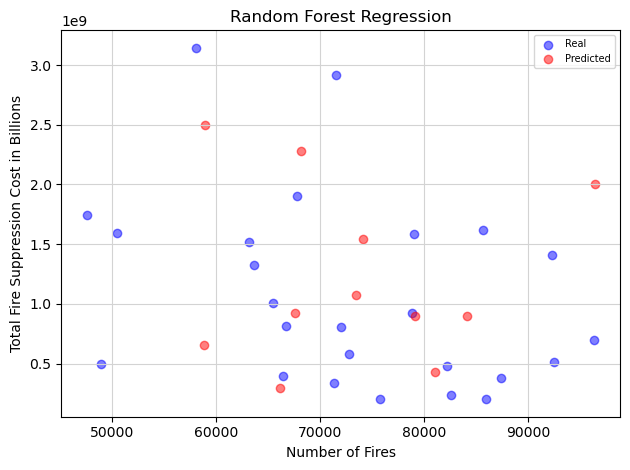

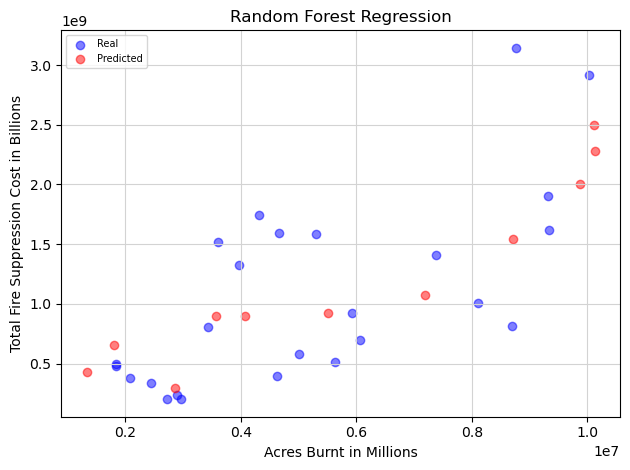

In [13]:
# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Fires.'
X_train_1 = X_train.iloc[:, 0]
X_test_1 = X_test.iloc[:, 0]

# Scatter plot
plt.scatter(X_train_1, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_1, y_pred_1, label='Predicted', color='r', alpha=0.5)
plt.title('Random Forest Regression')
plt.xlabel('Number of Fires')
plt.ylabel('Total Fire Suppression Cost in Billions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()

# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Acres Burnt.'
X_train_1 = X_train.iloc[:, 1]
X_test_1 = X_test.iloc[:, 1]

# Scatter plot
plt.scatter(X_train_1, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_1, y_pred_1, label='Predicted', color='r', alpha=0.5)
plt.title('Random Forest Regression')
plt.xlabel('Acres Burnt in Millions')
plt.ylabel('Total Fire Suppression Cost in Billions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# Tuning the parameters
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [2, 3, 5, 10, 20, 30, 40],
    'n_estimators': [10, 20, 30, 40, 50, 100]}

#gridforest = GridSearchCV(model_1, parameters, cv=5, n_jobs=-1, verbose=1)
gridforest = GridSearchCV(model_1, parameters, cv=5, verbose=1)
gridforest.fit(X_train, y_train)
print('The best paramters are:', gridforest.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
The best paramters are: {'max_depth': 5, 'n_estimators': 20}


In [15]:
# Gauge feature importances
# Get features list ('Fires' and 'Acres Burnt')
features = X.columns

# Get the variables importances, sort them, and print the result
importances = list(model_1.feature_importances_)
features_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
features_importances = sorted(features_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:30} Importance: {}'.format(*pair)) for pair in features_importances];

Feature: Acres Burnt                    Importance: 0.7675
Feature: Fires                          Importance: 0.2325


### KNN Regression ###

In [16]:
# Implement KNN Regression Model

# X, the dependent feature, consists of 'Fires' and 'Acres Burnt.' It is set with y in mind.
# Y, the independent variable, which is 'Total Fire Suppression Cost' 
# Split the data into features (X) and target (y)
X = df.iloc[:, [1,2]]
y = df.iloc[:, 3]

# Split the data into training and test sets. 30% testing, 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create KNeighbors Regression object
model_2 = KNeighborsRegressor(n_neighbors=8)

# Train KNeighborsRegressor
model_2.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_2 = model_2.predict(X_test)

In [17]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_2), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_2), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_2, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_2), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_2), '.4f'))

Mean Absolute Error (MAE): 309116556.8182
Mean Squared Error (MSE): 169098808443336640.0000
Root Mean Squared Error (RMSE): 411216255.0816
Mean Absolute Percentage Error (MAPE): 0.2938
R Squared: 0.6675


RMSE value is high here. With MAE in mind, the average estimate is off by 321,875,727.77. An R Squared or classification rate of 66.75% is considered good accuracy.

In [18]:
# Find the optimal k value by leveraging RMSE
# Store RMSE values for varying k values
rmse_value = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    error = format(sqrt(mean_squared_error(y_test, prediction)), '.4f')
    rmse_value.append(error) 
    print('The RMSE value for k =' , K , 'is:', error)

The RMSE value for k = 1 is: 712581096.1894
The RMSE value for k = 2 is: 454527863.2180
The RMSE value for k = 3 is: 439763215.5618
The RMSE value for k = 4 is: 469208514.1178
The RMSE value for k = 5 is: 449676485.5932
The RMSE value for k = 6 is: 456086075.5902
The RMSE value for k = 7 is: 427480558.7469
The RMSE value for k = 8 is: 411216255.0816
The RMSE value for k = 9 is: 418386806.6883
The RMSE value for k = 10 is: 452609713.9646


The optimal K value is found at K = 8.

### Decision Tree Regression ###

In [19]:
# Implement Decision Tree Regression Model

# X, the dependent feature, consists of 'Fires' and 'Acres Burnt.' It is set with y in mind.
# Y, the independent variable, which is 'Total Fire Suppression Cost' 
# Split the data into features (X) and target (y)
X = df.iloc[:, [1,2]]
y = df.iloc[:, 3]

# Split the data into training and test sets. 30% testing, 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create Decision Tree Regression object
model_3 = DecisionTreeRegressor()

# Train Decision Tree Classifer
model_3.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_3 = model_3.predict(X_test)

In [20]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_3), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_3), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_3, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_3), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_3), '.4f'))

Mean Absolute Error (MAE): 394497727.2727
Mean Squared Error (MSE): 263071536476454528.0000
Root Mean Squared Error (RMSE): 512904997.5156
Mean Absolute Percentage Error (MAPE): 0.3540
R Squared: 0.4827


An R Squared or classification rate of 48.27% is considered poor accuracy.

In [21]:
# Gauge feature importances
# Get features list ('Fires' and 'Acres Burnt')
features = X.columns

# Get the variables importances, sort them, and print the result
importances = list(model_3.feature_importances_)
features_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
features_importances = sorted(features_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:30} Importance: {}'.format(*pair)) for pair in features_importances];

Feature: Acres Burnt                    Importance: 0.7428
Feature: Fires                          Importance: 0.2572


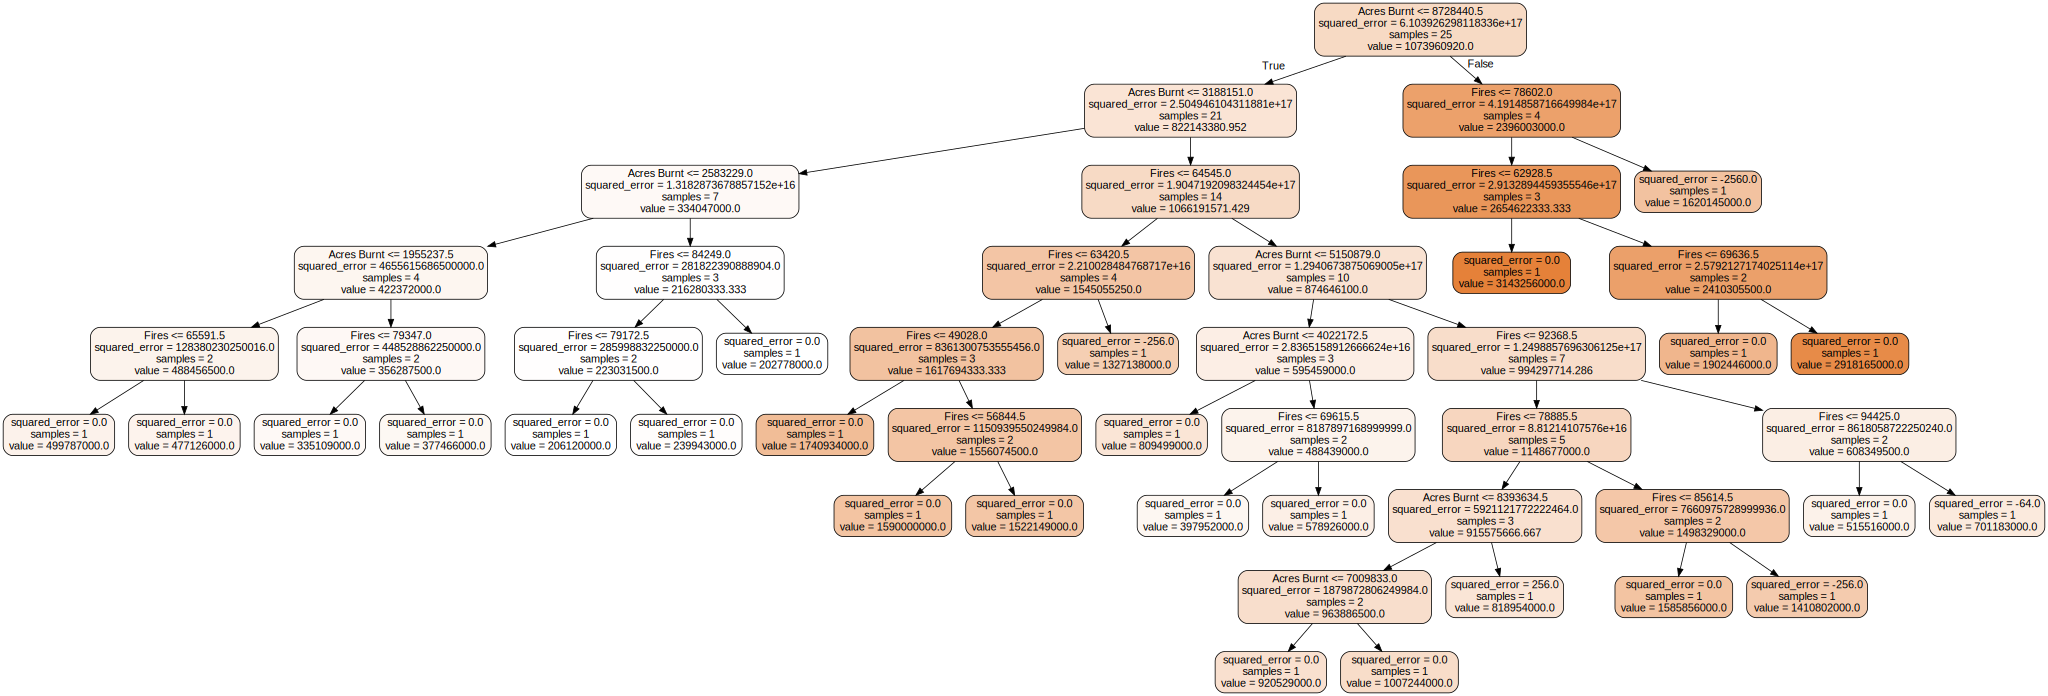

In [22]:
import graphviz
from sklearn import tree

#X = df.iloc[:, 1]
X = df.iloc[:, [1,2]]
y = df.iloc[:, 3]

# Split the data into training and test sets. 30% testing, 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  
# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
dot_data = tree.export_graphviz(model_3, out_file=None, feature_names=['Fires', 'Acres Burnt'], 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [23]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(model_3, out_file=None, feature_names=['Fires', 'Acres Burnt'], 
                                filled=True, rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data) 
pydot_graph.set_size('"200!, 200!"')
pydot_graph.write_png('tree.png')
Image(pydot_graph.create_png()) 

### Linear Regression ###

In [24]:
# Implement Linear Regression Model

# X, the dependent feature, consists of 'Fires' and 'Acres Burnt.' It is set with y in mind.
# Y, the independent variable, which is 'Total Fire Suppression Cost' 
# Split the data into features (X) and target (y)
X = df.iloc[:, [1,2]]
y = df.iloc[:, 3]

# Split the data into training and test sets. 20% testing, 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_4 = LinearRegression()
model_4.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_4 = model_4.predict(X_test)

# Accuracy score of model_1
round(model_4.score(X_test, y_test), 4)

0.6824

In [25]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_4), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_4), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_4, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_4), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_4), '.4f'))

Mean Absolute Error (MAE): 351120306.9053
Mean Squared Error (MSE): 164068794176010688.0000
Root Mean Squared Error (RMSE): 405054063.2755
Mean Absolute Percentage Error (MAPE): 0.4611
R Squared: 0.6824


An R Squared or classification rate of 68.24% is considered good accuracy.

In [26]:
# Gauge feature importances
# Get features list ('Fires' and 'Acres Burnt')
features = X.columns

# Get the variables importances, sort them, and print the result
importances = list(model_4.coef_)
features_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
features_importances = sorted(features_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:30} Coefficients: {}'.format(*pair)) for pair in features_importances];

Feature: Acres Burnt                    Coefficients: 221.7577
Feature: Fires                          Coefficients: -20495.3911


In [27]:
# Look at shapes of training and test shapes to ensure they align for graphing + visualizing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred_4.shape)

(28, 2)
(28,)
(8, 2)
(8,)
(8,)


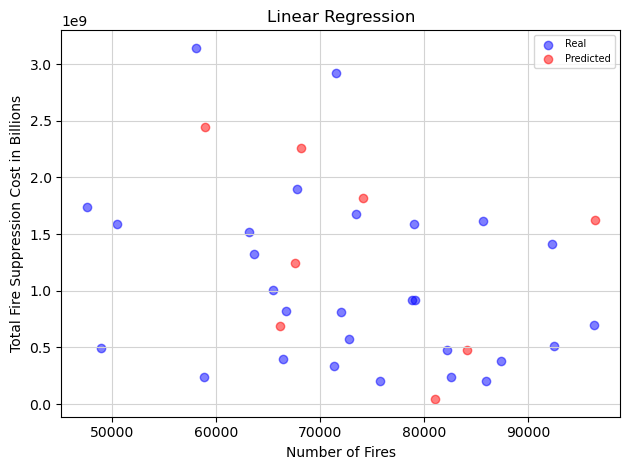

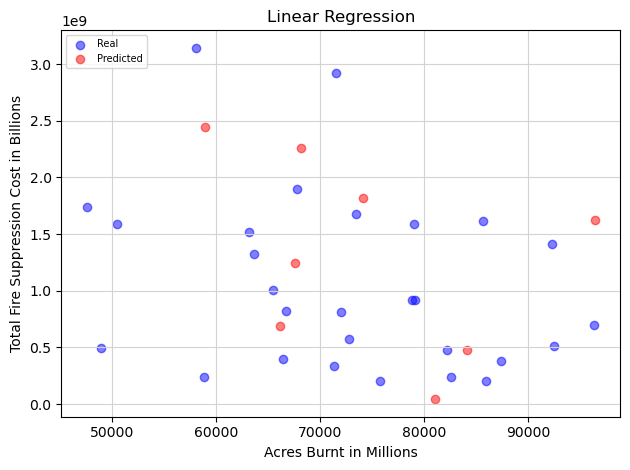

In [28]:
# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Fires.'
X_train_4 = X_train.iloc[:, 0]
X_test_4= X_test.iloc[:, 0]

# Scatter plot
plt.scatter(X_train_4, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_4, y_pred_4, label='Predicted', color='r', alpha=0.5)
plt.title('Linear Regression')
plt.xlabel('Number of Fires')
plt.ylabel('Total Fire Suppression Cost in Billions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()

# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Acres Burnt.'
X_train_1 = X_train.iloc[:, 1]
X_test_1 = X_test.iloc[:, 1]

# Scatter plot
plt.scatter(X_train_4, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_4, y_pred_4, label='Predicted', color='r', alpha=0.5)
plt.title('Linear Regression')
plt.xlabel('Acres Burnt in Millions')
plt.ylabel('Total Fire Suppression Cost in Billions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

## Takeaways ##

Three models performed very simialarly which came as a surprise while the other did not, so it will be disregarded.

Below are model performance results:
1. Random Forest (model_1)
    - Root Mean Squared Error (RMSE): 165689404090539552
    - Mean Absolute Percentage Error (MAPE): 0.2946
    - R Squared: 67.42%
2. KNN Regression (model_2)
    - Root Mean Squared Error (RMSE): 169098808443336640
    - Mean Absolute Percentage Error (MAPE): 0.2938
    - R Squared: 66.75%
3. Decision Tree (model_3)
    - Root Mean Squared Error (RMSE): 263071536476454528
    - Mean Absolute Percentage Error (MAPE): 0.3540
     - R Squared: 48.27%
4. Linear Regression (model_4)
    - Root Mean Squared Error (RMSE): 164068794176010688
    - Mean Absolute Percentage Error (MAPE): 0.4611
    - R Squared: 68.24%

The Random Forest model performed the best, so it will be leveraged.